In [2]:
import pandas as pd
import requests
from urllib.parse import urlencode
import json, datetime
# import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline

# mpl.style.use('seaborn')
api_key = "94bd224fdd23e740f91f7fc88375518f"


In [3]:
from datetime import datetime

def _dict_to_val(_dict):
    try:
        return list(_dict.values())[0]
    except:
        return 0
    
def temp_odcz(temp, wind_speed):
    return 13.12 + 0.6215 * temp - 11.37 * wind_speed**0.16 + 0.3965 * temp * wind_speed**0.16

def temp_pkt_rosy(temp, humidity):
    return (humidity/100)**(1/float(8)) * abs(112 + (0.9 * temp)) + (0.1 * temp) - 112

def getDateFrame(city, date):
    url = 'http://api.openweathermap.org/data/2.5/forecast?q={}&units=metric&APPID={}'.format(city, api_key)
    r = requests.get(url)
    weather = json.loads(r.text)
    df = pd.DataFrame.from_dict(weather['list'])

    df["clouds"] = df.apply(lambda x: x.clouds["all"], axis=1)
    df["rain"] = df.apply(lambda x: _dict_to_val(x.rain) if hasattr(x, 'rain') else 0, axis=1)
    df["snow"] = df.apply(lambda x: _dict_to_val(x.snow), axis=1)
    df["sys"] = df.apply(lambda x: list(x.sys["pod"]), axis=1)
    df["dt_txt1"] = df.apply(lambda x: datetime.strptime(x.dt_txt, '%Y-%m-%d %H:%M:%S'), axis=1)
    df["date"] = df.apply(lambda x: x.dt_txt1.date(), axis=1)
    df["time"] = df.apply(lambda x: x.dt_txt1.time(), axis=1)

    df  = df.merge(df.wind.apply(lambda s: pd.Series({'wind_speed':s["speed"], 'wind_deg':s["deg"]})), 
    left_index=True, right_index=True)
    df = df.merge(df.main.apply(lambda s: pd.Series({'temp':s["temp"], 'temp_min':s["temp_min"], 'temp_max':s["temp_max"], 'pressure': s['pressure'], "sea_level": s["sea_level"], "grnd_level": s["grnd_level"], "humidity": s["humidity"], "temp_kf": s["temp_kf"]})), 
    left_index=True, right_index=True)

    df = df.drop(columns=["main", "wind", "weather", "dt_txt"])

    pd.options.mode.chained_assignment = None  # default='warn'
    pd.set_option('display.max_columns',500)


    df["wind_speed_kmh"] = df.apply(lambda x: x.wind_speed * 3.6, axis=1)
    df["temp_odcz"] = df.apply(lambda row: temp_odcz(row.temp, row.wind_speed), axis=1)
    df["temp_odcz_min"] = df.apply(lambda row: temp_odcz(row.temp_min, row.wind_speed), axis=1)
    df["temp_odcz_max"] = df.apply(lambda row: temp_odcz(row.temp_max, row.wind_speed), axis=1)
    df["temp_pkt_rosy"] = df.apply(lambda row: temp_pkt_rosy(row.temp, row.humidity), axis=1)

    df2 = df.loc[df["date"] == datetime.strptime(date, "%Y-%m-%d").date()]
    return df2

In [5]:
chosenDf = getDateFrame("Warsaw", "2019-01-20")
chosenDf

,clouds,dt,snow,sys,rain,dt_txt1,date,time,wind_deg,wind_speed,grnd_level,humidity,pressure,sea_level,temp,temp_kf,temp_max,temp_min,wind_speed_kmh,temp_odcz,temp_odcz_min,temp_odcz_max,temp_pkt_rosy
2,32,1547942400,0.00600,[n],0,2019-01-20 00:00:00,2019-01-20,00:00:00,182.009,1.42,1021.83,88.0,1021.83,1034.79,-4.38,-0.11,-4.27,-4.38,5.112,-3.465211,-3.465211,-3.350714,-6.092955
3,8,1547953200,0.00200,[n],0,2019-01-20 03:00:00,2019-01-20,03:00:00,172.501,1.36,1020.96,83.0,1020.96,1033.86,-5.21,0.00,-5.21,-5.21,4.896,-4.231317,-4.231317,-4.231317,-7.680519
4,8,1547964000,0.00050,[n],0,2019-01-20 06:00:00,2019-01-20,06:00:00,181.002,1.36,1020.30,78.0,1020.30,1033.40,-6.41,0.00,-6.41,-6.41,4.896,-5.476910,-5.476910,-5.476910,-9.658580
5,24,1547974800,0.00375,[d],0,2019-01-20 09:00:00,2019-01-20,09:00:00,232.001,1.77,1020.48,89.0,1020.48,1033.48,-3.91,0.00,-3.91,-3.91,6.372,-3.466335,-3.466335,-3.466335,-5.478760
6,32,1547985600,0.00750,[d],0,2019-01-20 12:00:00,2019-01-20,12:00:00,273.501,2.10,1019.83,100.0,1019.83,1032.69,-1.31,0.00,-1.31,-1.31,7.560,-1.082161,-1.082161,-1.082161,-1.310000
7,64,1547996400,0.01875,[d],0,2019-01-20 15:00:00,2019-01-20,15:00:00,294.000,2.21,1019.79,90.0,1019.79,1032.51,-2.01,0.00,-2.01,-2.01,7.956,-1.942120,-1.942120,-1.942120,-3.451708
8,32,1548007200,0.01750,[n],0,2019-01-20 18:00:00,2019-01-20,18:00:00,282.002,2.66,1020.00,89.0,1020.00,1033.01,-2.94,0.00,-2.94,-2.94,9.576,-3.367076,-3.367076,-3.367076,-4.521384
9,36,1548018000,0.00250,[n],0,2019-01-20 21:00:00,2019-01-20,21:00:00,278.004,2.81,1020.80,88.0,1020.80,1033.81,-4.81,0.00,-4.81,-4.81,10.116,-5.533260,-5.533260,-5.533260,-6.516820


In [14]:
def plot_humidity(df2, ax1):
    ax1.cla()
    ax1.set_ylim(0,120)

    t_dict = {}
    tList = []
    t = 0
    date_time_list = df2["dt_txt1"].tolist()
    while t < len(date_time_list):
        ti = int(time.mktime(date_time_list[t].timetuple()))
        t_dict[ti] = date_time_list[t]
        tList.append(ti)
        t = t + 1

    ax1.plot(tList, df2["humidity"],'ro')
    print(tList)
    z = np.polyfit(tList, df2["humidity"], 25)
    f = np.poly1d(z)
    x_new = np.linspace(tList[0], tList[-1], 50)
    y_new = f(x_new)
    ax1.plot(x_new, y_new, color="blue")

    ax1.set_ylabel('Humidity')
    ax1.autoscale(axis="x", tight=True)

    ax2_humidity = ax1.twinx()
    color = 'tab:blue'
    ax2_humidity.bar([t -500 for t in tList], df2["snow"], color=color, width=1000)
    ax2_humidity.tick_params(axis='y', labelcolor=color)
    ax2_humidity.set_ylim([df2["snow"].min() ,df2["snow"].max() + 10])

    color = 'tab:green'
    ax2_humidity.bar([t +500 for t in tList], df2["rain"], color=color, width=1000)

    ax2_humidity.set_xticklabels([])
    ax2_humidity.autoscale(axis="x", tight=True)

[1547938800, 1547949600, 1547960400, 1547971200, 1547982000, 1547992800, 1548003600, 1548014400]


/usr/local/lib/python3.5/dist-packages/numpy/lib/polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned


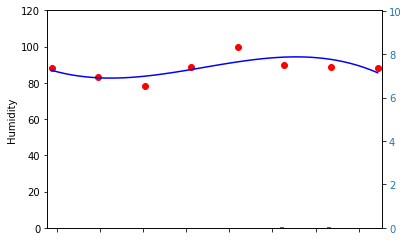

In [15]:
import time

fig, ax = plt.subplots()

plot_humidity(chosenDf, ax)

In [6]:
import math
def get_change(deg, radius):
    rad = math.radians(deg % 360);
    dx = radius * math.cos(rad);
    dy = -radius * math.sin(rad);
    return [dx, dy];

def plot_wind_direction(date_df):
    fig, ax = plt.subplots()
    plt.xlim(-3,24)
    plt.ylim(-15,15)
    x = date_df["dt_txt1"].dt.hour
    plt.xticks(x)

    for hour,deg in zip(x,date_df["wind_deg"]):
        vector = get_change(deg - 90, 3)
        print(hour, deg)
        plt.arrow(hour,  
                  0,
                  vector[0],
                  vector[1], 
                  color="b",
                  head_width = 0.5,
                  head_length = 1)
    plt.show()

0 195.0
3 185.0
6 182.001
9 191.003
12 196.5
15 193.002
18 187.501
21 174.001


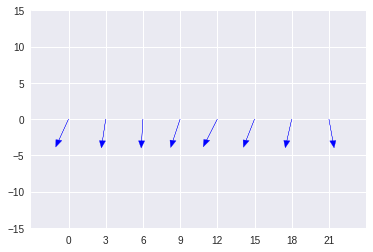

In [7]:
plot_wind_direction(chosenDf)

In [8]:
with open("input_data_config.json") as json_data:
    d = json.load(json_data)
    data = pd.DataFrame.from_dict(d['list'])
data

,city_name,x,y
0,Warsaw,680,435
1,Gdańsk,440,80
2,Szczecin,50,220
3,Olsztyn,615,170
4,Bydgoszcz,380,285
5,Białystok,880,270
6,Poznań,270,390
7,Gorzów wielkopolski,110,340
8,Lublin,840,590
9,Łódź,520,510


Warsaw 188.001
Gdańsk 179.1885
Szczecin 267.0635
Olsztyn 176.626
Bydgoszcz 186.6885
Białystok 183.9385
Poznań 244.25099999999998
Gorzów wielkopolski 258.876
Lublin 195.5635
Łódź 213.876
Wrocław 244.31349999999998
Opole 227.00099999999998
Katowice 222.876
Kraków 213.126
Kielce 210.001
Rzeszów 196.8135


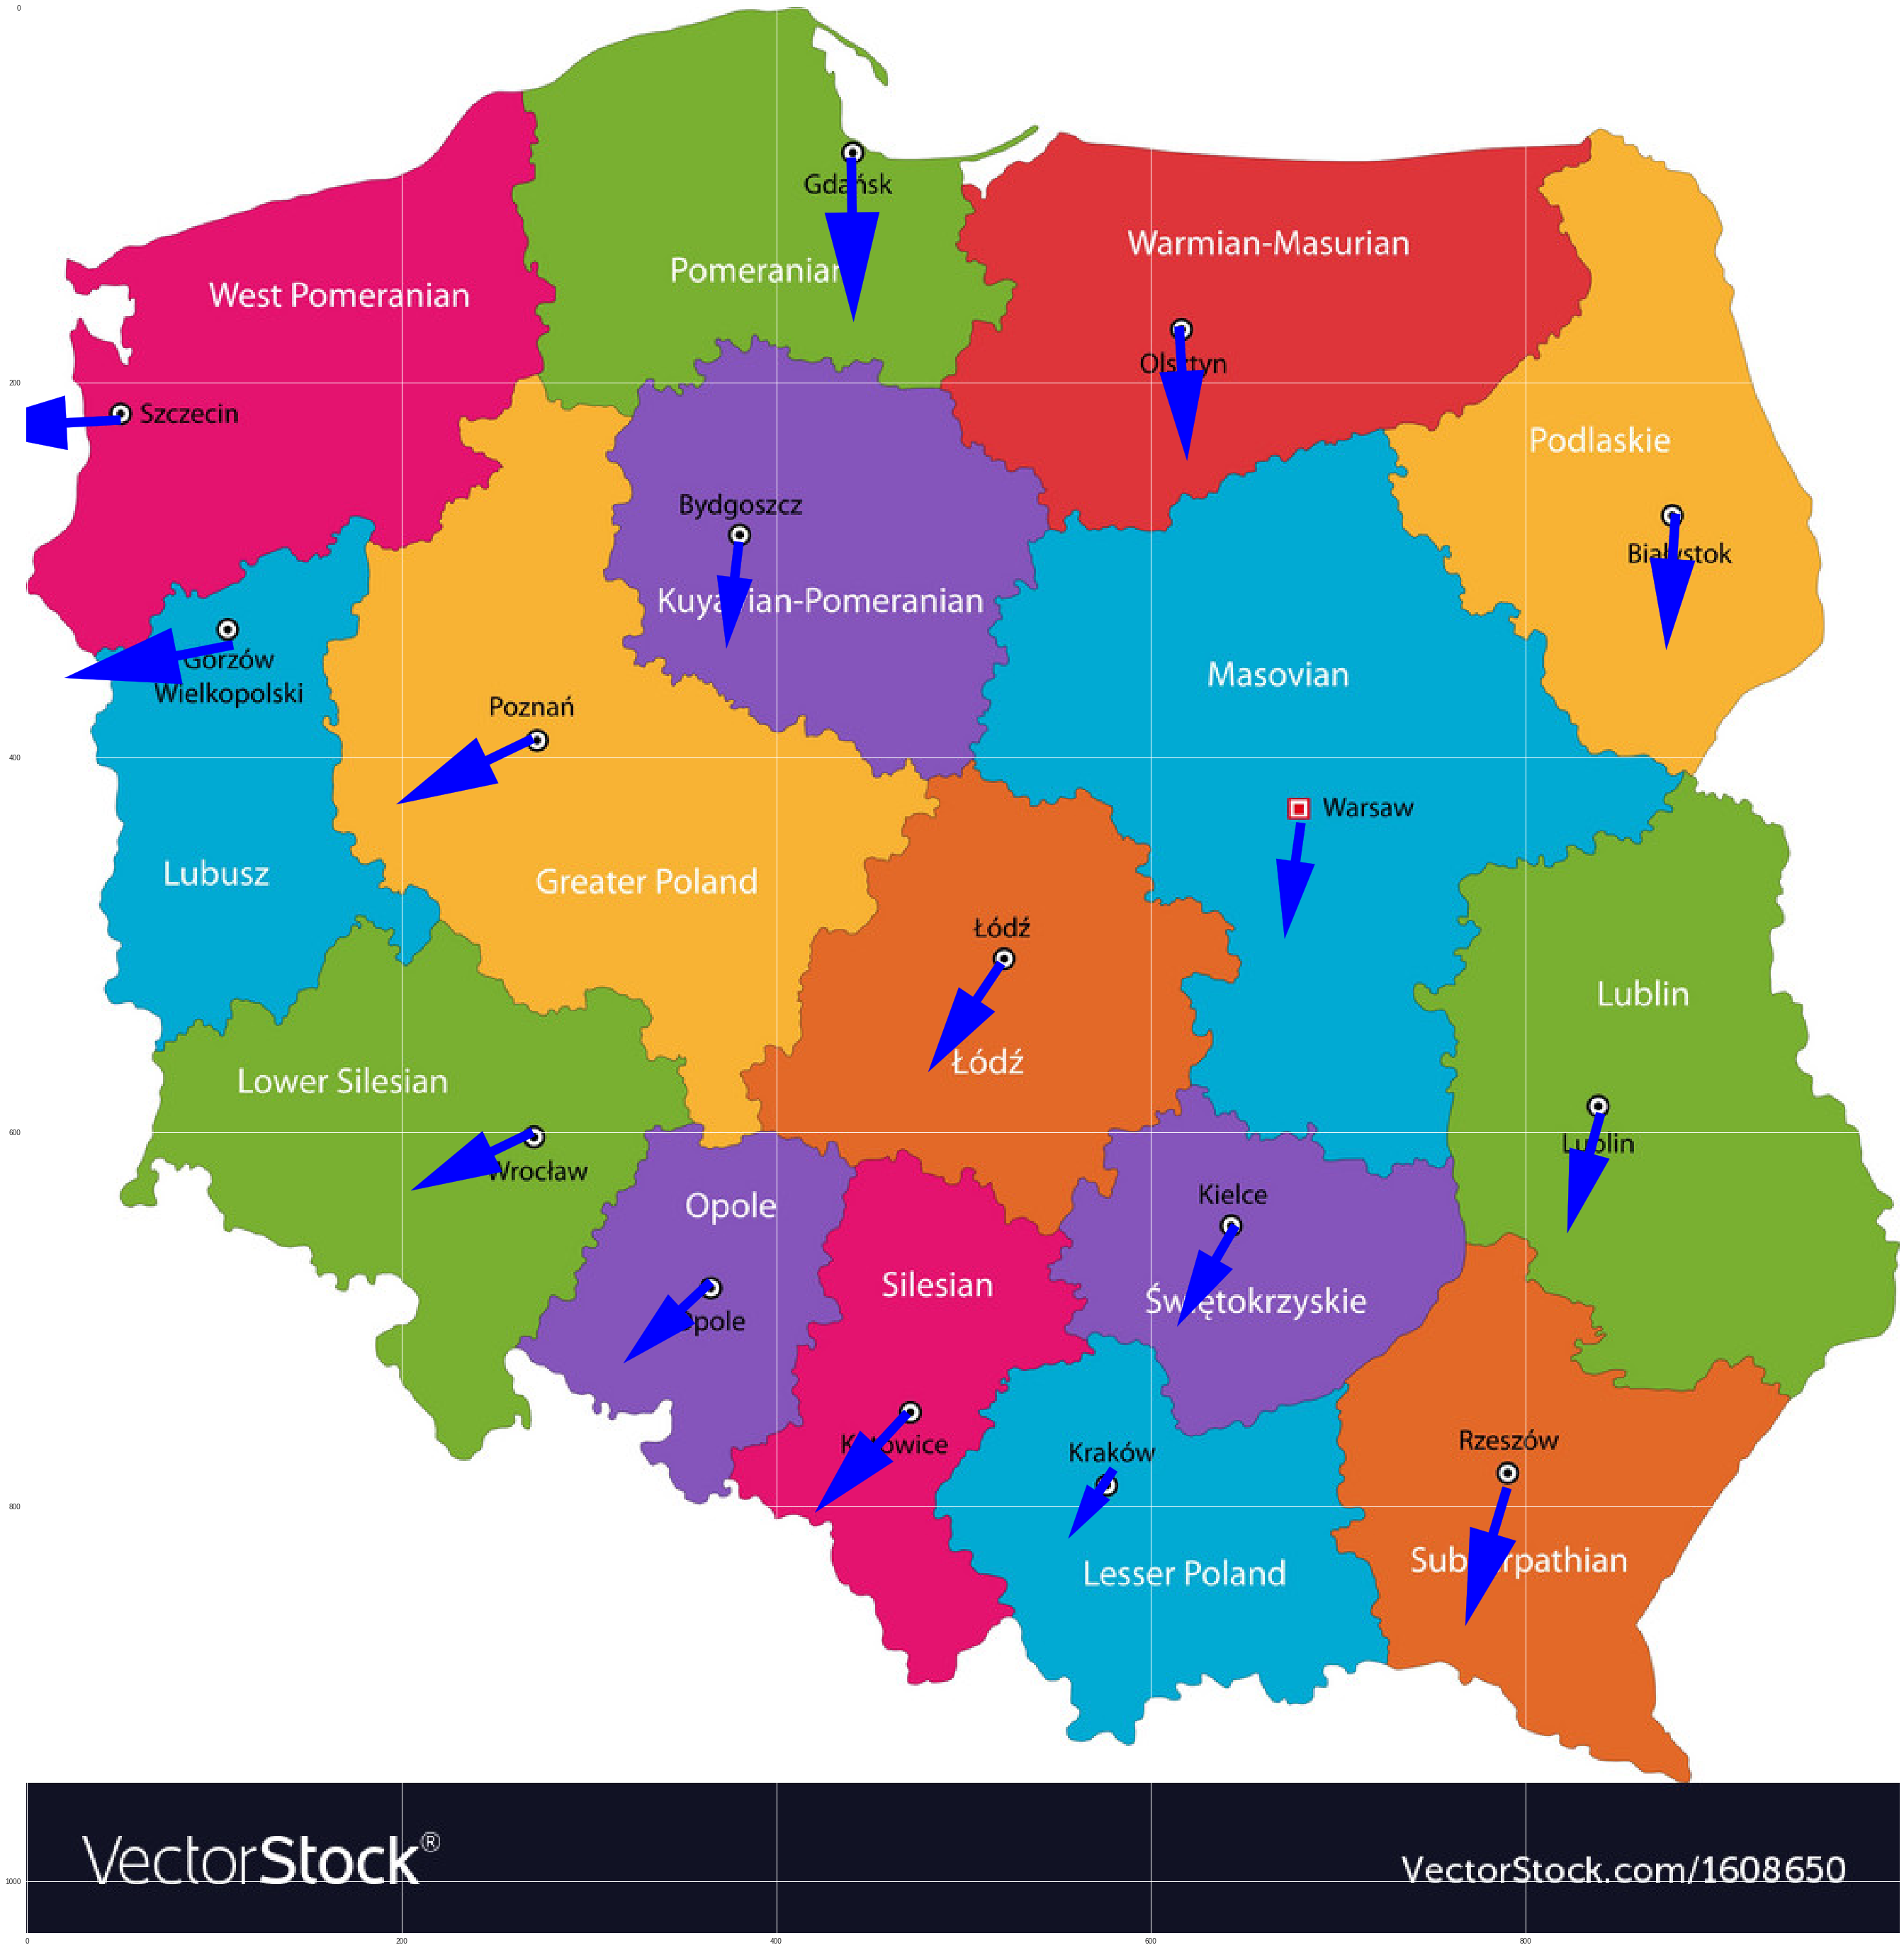

In [9]:
img = plt.imread("poland.jpg")
fig, ax = plt.subplots()
fig.set_size_inches(50,50)
for city,x,y in zip(data["city_name"], data["x"], data["y"]):
    df = getDateFrame(city, "2019-01-08")
    deg = df["wind_deg"].mean()
    speed = df["wind_speed_kmh"].mean()
    vector = get_change(deg - 90, speed)
    print(city,deg)
    ax.arrow(x,  
             y,
             vector[0],
             -vector[1], 
             width = 5,
             color="b",
             head_width = speed,
             head_length = speed*2)
ax.imshow(img)
fig.savefig("poland_plane.jpg")

In [10]:
import numpy as np

class Point2D:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def to_vector(self):
        return [self.x, self.y]


class Point3D:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        self.w = 1

    def to_vector(self):
        return (self.x, self.y, self.z)
    
    def to_np_array(self):
        return np.array([self.x, self.y, self.z])

    def out_of_camera(self):
        return self.z <= 0

    def update_from_vector(self, vector):
        self.x = vector[0]
        self.y = vector[1]
        self.z = vector[2]
        self.w = vector[3]


class Polygon:
    def __init__(self, vectors, color):
        self.vectors = vectors
        self.color = color
        self.points = self.set_points()

    def set_points(self):
        return [x for x in self.vectors]

    def dist_to_observator(self):
        pt = Point3D(np.sum(map(lambda point: point.x, self.points))/len(self.points),
                   np.sum(map(lambda point: point.y, self.points))/len(self.points),
                   np.sum(map(lambda point: point.z, self.points))/len(self.points))
        distance = np.sqrt(pt.x**2 + pt.y**2 + pt.z**2)
        return distance

    def max_z(self):
        return np.max(map(lambda point: point[2], self.points))

    def min_z(self):
        return np.min(map(lambda point: point[2], self.points))
    
    def to_list(self):
        list_of_points = []
        for v in self.vectors:
            list_of_points += v.to_list()
        return list(np.array(p) for p in set(list_of_points))


class Vector:
    def __init__(self, a, b):
        self.a = a
        self.b = b
        
    def to_list(self):
        return (self.a.to_vector(), self.b.to_vector())


class Cuboid:
    def __init__(self, x, y, z, width, height, color):
        self.x = x
        self.y = y
        self.z = z
        self.width = width
        self.height = height
        self.color = color
        self.polygons = []
        self.create_walls()

    def create_walls(self):
        self.create_front_wall()
        self.create_back_wall()
        self.create_bottom_wall()
        self.create_top_wall()
        self.create_left_wall()
        self.create_right_wall()

    def create_front_wall(self):
        vectors = []
        vectors.append(Vector(Point3D(self.x, self.y, self.z)
                              , Point3D(self.x + self.width, self.y, self.z)))

        vectors.append(Vector(Point3D(self.x + self.width, self.y, self.z),
                              Point3D(self.x + self.width, self.y + self.height, self.z)))

        vectors.append(Vector(Point3D(self.x + self.width, self.y + self.height, self.z),
                              Point3D(self.x, self.y + self.height, self.z)))

        vectors.append(Vector(Point3D(self.x, self.y + self.height, self.z),
                              Point3D(self.x, self.y, self.z)))

        self.polygons.append(Polygon(vectors, self.color))

    def create_back_wall(self):
        vectors = []
        vectors.append(Vector(Point3D(self.x, self.y, self.z + self.height),
                              Point3D(self.x + self.width, self.y, self.z + self.height)))
        vectors.append(Vector(Point3D(self.x + self.width, self.y, self.z + self.height),
                              Point3D(self.x + self.width, self.y + self.height, self.z + self.height)))
        vectors.append(Vector(Point3D(self.x + self.width, self.y + self.height, self.z + self.height),
                              Point3D(self.x, self.y + self.height, self.z + self.height)))
        vectors.append(Vector(Point3D(self.x, self.y + self.height, self.z + self.height),
                              Point3D(self.x, self.y, self.z + self.height)))
        self.polygons.append(Polygon(vectors, self.color))

    def create_bottom_wall(self):
        vectors = []
        vectors.append(Vector(Point3D(self.x, self.y, self.z),
                              Point3D(self.x, self.y, self.z + self.height)))
        vectors.append(Vector(Point3D(self.x, self.y, self.z + self.height),
                              Point3D(self.x + self.width, self.y, self.z + self.height)))
        vectors.append(Vector(Point3D(self.x + self.width, self.y, self.z + self.height),
                              Point3D(self.x + self.width, self.y, self.z)))
        vectors.append(Vector(Point3D(self.x + self.width, self.y, self.z),
                              Point3D(self.x, self.y, self.z)))
        self.polygons.append(Polygon(vectors, self.color))

    def create_top_wall(self):
        vectors = []
        vectors.append(Vector(Point3D(self.x, self.y + self.height, self.z),
                              Point3D(self.x, self.y + self.height, self.z + self.height)))
        vectors.append(Vector(Point3D(self.x, self.y + self.height, self.z + self.height),
                              Point3D(self.x + self.width, self.y + self.height, self.z + self.height)))
        vectors.append(Vector(Point3D(self.x + self.width, self.y + self.height, self.z + self.height),
                              Point3D(self.x + self.width, self.y + self.height, self.z)))
        vectors.append(Vector(Point3D(self.x + self.width, self.y + self.height, self.z),
                              Point3D(self.x, self.y + self.height, self.z)))
        self.polygons.append(Polygon(vectors, self.color))

    def create_left_wall(self):
        vectors = []
        vectors.append(Vector(Point3D(self.x, self.y, self.z),
                              Point3D(self.x, self.y, self.z + self.height)))
        vectors.append(Vector(Point3D(self.x, self.y, self.z + self.height),
                              Point3D(self.x, self.y + self.height, self.z + self.height)))
        vectors.append(Vector(Point3D(self.x, self.y + self.height, self.z + self.height),
                              Point3D(self.x, self.y + self.height, self.z)))
        vectors.append(Vector(Point3D(self.x, self.y + self.height, self.z),
                              Point3D(self.x, self.y, self.z)))
        self.polygons.append(Polygon(vectors, self.color))

    def create_right_wall(self):
        vectors = []
        vectors.append(Vector(Point3D(self.x + self.width, self.y, self.z),
                              Point3D(self.x + self.width, self.y, self.z + self.height)))
        vectors.append(Vector(Point3D(self.x + self.width, self.y, self.z + self.height),
                              Point3D(self.x + self.width, self.y + self.height, self.z + self.height)))
        vectors.append(Vector(Point3D(self.x + self.width, self.y + self.height, self.z + self.height),
                              Point3D(self.x + self.width, self.y + self.height, self.z)))
        vectors.append(Vector(Point3D(self.x + self.width, self.y + self.height, self.z),
                              Point3D(self.x + self.width, self.y, self.z)))
        self.polygons.append(Polygon(vectors, self.color))
    
    def get_vertices_and_faces(self):
        edges = self.get_edges()
        vertices = list(set(tuple(p.tolist()) for edge in edges for p in edge))
        faces = []
        for polygon in self.polygons:
            _points = [tuple(p.tolist()) for p in polygon.to_list()]
            faces.append([vertices.index(p) for p in _points])
        return vertices, faces
    
    def get_edges(self):
        return [p.to_list() for p in self.polygons]

In [11]:
import vtk

def vtk_cube(center, val):
    def mkVtkIdList(it):
        vil = vtk.vtkIdList()
        for i in it:
            vil.InsertNextId(int(i))
        return vil
    x_center, y_center, z_center = center
    cube_constructor = Cuboid(x_center, y_center, z_center, val, 0.03, "blue")
    x, pts = cube_constructor.get_vertices_and_faces()

    cube    = vtk.vtkPolyData()
    points  = vtk.vtkPoints()
    polys   = vtk.vtkCellArray()
    scalars = vtk.vtkFloatArray()
    for i in range(8):
        points.InsertPoint(i, x[i])
    for i in range(6):
        polys.InsertNextCell( mkVtkIdList(pts[i]) )
    for i in range(8):
        scalars.InsertTuple1(i,i)
    cube.SetPoints(points)
    del points
    cube.SetPolys(polys)
    del polys
    cube.GetPointData().SetScalars(scalars)
    del scalars
    cubeMapper = vtk.vtkPolyDataMapper()
    if vtk.VTK_MAJOR_VERSION <= 5:
        cubeMapper.SetInput(cube)
    else:
        cubeMapper.SetInputData(cube)
    cubeMapper.SetScalarRange(0,7)
    cubeActor = vtk.vtkActor()
    cubeActor.SetMapper(cubeMapper)
    return cubeActor

In [12]:
import vtk
import math

camera = vtk.vtkCamera()
camera.SetPosition(1,1,1)
camera.SetFocalPoint(0,0,0)

renderer = vtk.vtkRenderer()
renWin   = vtk.vtkRenderWindow()
renWin.AddRenderer(renderer)

iren = vtk.vtkRenderWindowInteractor()
iren.SetRenderWindow(renWin)


plane = vtk.vtkPlaneSource()
plane.SetCenter(0.0, 0.0, 0.0)
plane.SetNormal(1.0, 0.0, 0.0)

reader = vtk.vtkJPEGReader()
reader.SetFileName("poland_plane.jpg")

map_to_plane = vtk.vtkTextureMapToPlane()
map_to_plane.SetInputConnection(plane.GetOutputPort())


mapper = vtk.vtkPolyDataMapper()
mapper.SetInputConnection(map_to_plane.GetOutputPort())


texture = vtk.vtkTexture()
texture.SetInputConnection(reader.GetOutputPort())

actor = vtk.vtkActor()
actor.SetMapper(mapper)
actor.SetTexture(texture)
renderer.AddActor(actor)

for city,x,y in zip(data["city_name"], data["x"], data["y"]):
    df = getDateFrame(city, "2019-01-08")
    val = df["humidity"].mean()
    cubeActor = vtk_cube((0,x/700-0.72,-y/700+0.72), val/500)
    cubeActor.GetMapper().ScalarVisibilityOff()
    cubeActor.GetProperty().SetColor((0, 0, 255))
    cubeActor.GetProperty().SetInterpolationToFlat()
    scale_transform = vtk.vtkTransform()
    scale_transform.Scale(0.5, 0.5, 0.5)
    cubeActor.SetUserTransform(scale_transform)
    renderer.AddActor(cubeActor)

renderer.SetActiveCamera(camera)
renderer.ResetCamera()
renWin.SetSize(800,800)

renWin.Render()
iren.Start()

del cubeActor
del camera
del renderer
del renWin
del iren